# Web Scraping 

In [1]:
# import libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

We'll create 2 datasets: one - containing ratings that reviewers gave (values from the tables on the website), and another - containing only text reviews. For the 1st dataset we'll perform EDA and for the 2nd - Sentiment Analysis

In [2]:
columns = ['Date Flown','Aircraft','Type Of Traveller','Seat Type','Seat Comfort','Cabin Staff Service','Food & Beverages',
               'Inflight Entertainment','Ground Service','Value For Money','Wifi & Connectivity','Recommended']
# create 2 dataframes
df = pd.DataFrame(columns=columns)
df2 = pd.DataFrame(columns=['Text'])

temp_row1 = 0
temp_row2 = 0

# web scraping and adding values to our new dataframe
for i in range(1, math.ceil(3423/100)+1):
    URL = f'https://www.airlinequality.com/airline-reviews/british-airways/page/{i}/?sortby=post_date%3ADesc&pagesize=100'

    page = requests.get(URL)

    soup = BeautifulSoup(page.content, 'html.parser')

    reviews = soup.find_all('div', class_ = 'body')

    for review in reviews:
        table = review.find('table')
        fields = table.find_all('tr')
        for field in fields:
            attribute = field.find_all('td')[0].text
            value = field.find_all('td')[1].text
            rating = len(field.find_all('td')[1].find_all('span', class_ = "star fill"))
            if attribute in columns:
                if rating == 0:
                    df.loc[temp_row1, attribute] = value
                else:
                    df.loc[temp_row1, attribute] = rating
        temp_row1 += 1
    
    texts = soup.find_all('div', class_ = 'text_content')
    
    for text in texts:
        text = text.text[15:]        # without 'Trip Verified'/ 'Not Verified'
        df2.loc[temp_row2,'Text'] = text            # add value to dataframe
        temp_row2 += 1

# Quick EDA

In [3]:
df1 = df.copy()

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3440 entries, 0 to 3439
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Date Flown              2662 non-null   object
 1   Aircraft                1797 non-null   object
 2   Type Of Traveller       2670 non-null   object
 3   Seat Type               3438 non-null   object
 4   Seat Comfort            3342 non-null   object
 5   Cabin Staff Service     3334 non-null   object
 6   Food & Beverages        3108 non-null   object
 7   Inflight Entertainment  2421 non-null   object
 8   Ground Service          2604 non-null   object
 9   Value For Money         3440 non-null   object
 10  Wifi & Connectivity     508 non-null    object
 11  Recommended             3440 non-null   object
dtypes: object(12)
memory usage: 478.4+ KB


In [5]:
df1.head()

,Date Flown,Aircraft,Type Of Traveller,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money,Wifi & Connectivity,Recommended
0,December 2022,A320,Solo Leisure,Economy Class,2,3,NaN,NaN,1,1,NaN,no
1,October 2022,NaN,Business,Business Class,3,4,3,NaN,1,1,NaN,no
2,December 2022,NaN,Solo Leisure,Economy Class,2,2,2,2,1,1,NaN,no
3,November 2022,NaN,Couple Leisure,Premium Economy,4,1,1,3,1,1,NaN,no
4,December 2022,NaN,Solo Leisure,Premium Economy,3,5,4,3,1,4,NaN,no


In [6]:
# fill missing values in columns containing ratings (4:10) with corresponding median value 
for col in df1.iloc[:, 4:11].columns:
    df1[col].replace('N/A', np.nan, inplace=True)
    df1[col] = df1[col].astype('Int64').fillna(df1[col].median())
    
df1['Recommended'].replace(['yes', 'no'], [1, 0], inplace = True)                    # yes/no --> 1/0

In [7]:
# drop unnecessary features 
df1 = df1.iloc[:, 3:]
df1.head()

,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money,Wifi & Connectivity,Recommended
0,Economy Class,2,3,3,3,1,1,1,0
1,Business Class,3,4,3,3,1,1,1,0
2,Economy Class,2,2,2,2,1,1,1,0
3,Premium Economy,4,1,1,3,1,1,1,0
4,Premium Economy,3,5,4,3,1,4,1,0


In [8]:
# pivot table with ratings' median values estimated for each Seat Type
ratings_by_SeatType = df1.groupby(["Seat Type"]).median().astype(int)
ratings_by_SeatType

,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Value For Money,Wifi & Connectivity,Recommended
Seat Type,,,,,,,,
Business Class,3,4,3,3,3,3,1,0
Economy Class,3,3,3,3,3,3,1,0
First Class,4,4,3,3,3,3,1,0
Premium Economy,3,3,3,3,3,3,1,0


In [9]:
# ratings' median values
avr = df1.median().astype(int)
avr

C:\Users\User\AppData\Local\Temp/ipykernel_56792/2034191930.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avr = df1.median().astype(int)


Seat Comfort              3
Cabin Staff Service       4
Food & Beverages          3
Inflight Entertainment    3
Ground Service            3
Value For Money           3
Wifi & Connectivity       1
Recommended               0
dtype: int32

In [36]:
df1.Recommended.value_counts()/df1.Recommended.value_counts().sum()

0    0.579651
1    0.420349
Name: Recommended, dtype: float64

In [11]:
df.to_csv('raw_BritishAirwaysReviews.csv', na_rep='NaN', sep = ',')
df1.to_csv('pretty_BritishAirwayReviews.csv', na_rep='NaN', sep=',')
df2.to_csv('textReviews.csv', na_rep='NaN', sep=',')

In [12]:
#df1 = pd.read_csv('pretty_BritishAirwayReviews.csv')

# Sentiment Analysis

In [13]:
df2.head()

,Text
0,BA cancelled my flight home to Heathrow on De...
1,"BA cancelled my flight home, the last flight ..."
2,"| Turned up 3.5 hours in advance, Terminal 5 ..."
3,Boarding – at gate at LGW they called Group 1...
4,| Missing baggage customer service was the w...


In [14]:
df2 = df2.reset_index()
df2.head()

,index,Text
0,0,BA cancelled my flight home to Heathrow on De...
1,1,"BA cancelled my flight home, the last flight ..."
2,2,"| Turned up 3.5 hours in advance, Terminal 5 ..."
3,3,Boarding – at gate at LGW they called Group 1...
4,4,| Missing baggage customer service was the w...


## Basic NLTK

In [15]:
## Basic NLTK
import nltk
#nltk.download('punkt')
#nltk.download("book")
#nltk.download('vader_lexicon') 

Let's see how it works on a single example

In [16]:
example = df2['Text'][50]                 
example

' |  British Airways personnel was just magnificent. My flight into London was delayed, security had long lines, I ran like a madman to find the gate closed but the plane was still there… the lady at the gate worked the computer at 200 miles an hour to allow me to board (the software program was already closed). This while the flight manager, who came towards the gate, urging her to make a decision since the plane was about to loose its take off spot in line. I was sweating from the run, still out of breath while she handed me my passport giving me the green light to board. I bolted again into the plane feeling bad that I did not personally thank her for her magic. I really hope she gets recognized by British Airways for her performance. Thank you for all you do !'

In [17]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['|',
 'British',
 'Airways',
 'personnel',
 'was',
 'just',
 'magnificent',
 '.',
 'My',
 'flight']

In [18]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('|', 'JJ'),
 ('British', 'JJ'),
 ('Airways', 'NNP'),
 ('personnel', 'NN'),
 ('was', 'VBD'),
 ('just', 'RB'),
 ('magnificent', 'JJ'),
 ('.', '.'),
 ('My', 'PRP$'),
 ('flight', 'NN')]

In [19]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  |/JJ
  (GPE British/JJ)
  Airways/NNP
  personnel/NN
  was/VBD
  just/RB
  magnificent/JJ
  ./.
  My/PRP$
  flight/NN
  into/IN
  (GPE London/NNP)
  was/VBD
  delayed/VBN
  ,/,
  security/NN
  had/VBD
  long/JJ
  lines/NNS
  ,/,
  I/PRP
  ran/VBP
  like/IN
  a/DT
  madman/NN
  to/TO
  find/VB
  the/DT
  gate/NN
  closed/VBD
  but/CC
  the/DT
  plane/NN
  was/VBD
  still/RB
  there…/VBZ
  the/DT
  lady/NN
  at/IN
  the/DT
  gate/NN
  worked/VBD
  the/DT
  computer/NN
  at/IN
  200/CD
  miles/NNS
  an/DT
  hour/NN
  to/TO
  allow/VB
  me/PRP
  to/TO
  board/NN
  (/(
  the/DT
  software/NN
  program/NN
  was/VBD
  already/RB
  closed/VBN
  )/)
  ./.
  This/DT
  while/IN
  the/DT
  flight/NN
  manager/NN
  ,/,
  who/WP
  came/VBD
  towards/IN
  the/DT
  gate/NN
  ,/,
  urging/VBG
  her/PRP$
  to/TO
  make/VB
  a/DT
  decision/NN
  since/IN
  the/DT
  plane/NN
  was/VBD
  about/IN
  to/TO
  loose/VB
  its/PRP$
  take/VB
  off/RP
  spot/NN
  in/IN
  line/NN
  ./.
  I/PRP
  was/VBD
  swe

## Vader Sentiment Scoring
VADER (Valence Aware Dictionary and sEntiment Reasoner).
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.
This uses a "bag of words" approach:
1. Stop words are removed
2. each word is scored and combined to a total score.

In [20]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [21]:
sia = SentimentIntensityAnalyzer()

In [22]:
# let's see how it works
print(sia.polarity_scores('This is the worst thing ever.'))
print(sia.polarity_scores(example))

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}
{'neg': 0.075, 'neu': 0.792, 'pos': 0.133, 'compound': 0.7973}


In [23]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df2.iterrows(), total=len(df2)):
    text = row['Text']
    res[i] = sia.polarity_scores(text)

  0%|          | 0/3440 [00:00<?, ?it/s]

In [24]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().merge(df2, how='left')
vaders.head()

,index,neg,neu,pos,compound,Text
0,0,0.150,0.832,0.018,-0.9535,BA cancelled my flight home to Heathrow on De...
1,1,0.109,0.840,0.051,-0.7686,"BA cancelled my flight home, the last flight ..."
2,2,0.170,0.771,0.059,-0.9360,"| Turned up 3.5 hours in advance, Terminal 5 ..."
3,3,0.011,0.896,0.093,0.9873,Boarding – at gate at LGW they called Group 1...
4,4,0.064,0.919,0.016,-0.8151,| Missing baggage customer service was the w...


## Roberta Pretrained Model
- A model trained on a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [25]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [26]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [27]:
# Run Roberta Model on an example
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}

In [28]:
# Compare Vader and Roberta results
print(sia.polarity_scores(example))
print(scores_dict)

{'neg': 0.075, 'neu': 0.792, 'pos': 0.133, 'compound': 0.7973}
{'roberta_neg': 0.15425767, 'roberta_neu': 0.37080437, 'roberta_pos': 0.474938}


In [29]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict   

In [30]:
# Combine Vader and Roberta results of the 1st 100 reviews (due to computer's capacity)
res = {}
for i, row in tqdm(df2[:100].iterrows(), total = 100):
    try:
        text = row['Text']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[i] = both
    except RuntimeError:
        print(f"Broke for id {i}")

  0%|          | 0/100 [00:00<?, ?it/s]

Broke for id 75
Broke for id 95


In [31]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().merge(df2, how='left')
results_df

,index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Text
0,0,0.150,0.832,0.018,-0.9535,0.766331,0.201310,0.032359,BA cancelled my flight home to Heathrow on De...
1,1,0.109,0.840,0.051,-0.7686,0.654449,0.270956,0.074596,"BA cancelled my flight home, the last flight ..."
2,2,0.170,0.771,0.059,-0.9360,0.896497,0.093507,0.009996,"| Turned up 3.5 hours in advance, Terminal 5 ..."
3,3,0.011,0.896,0.093,0.9873,0.246401,0.513118,0.240482,Boarding – at gate at LGW they called Group 1...
4,4,0.064,0.919,0.016,-0.8151,0.775193,0.201326,0.023482,| Missing baggage customer service was the w...
...,...,...,...,...,...,...,...,...,...
93,94,0.102,0.816,0.082,-0.5239,0.938021,0.054896,0.007083,Terrible experience with British Airways! I w...
94,96,0.008,0.947,0.046,0.6428,0.570666,0.387013,0.042321,"| Belfast to London on 20 Jun, 0650. I was i..."
95,97,0.120,0.797,0.083,-0.3479,0.463944,0.355108,0.180948,The customer service of British Airways is re...
96,98,0.098,0.762,0.140,0.7347,0.128580,0.389591,0.481829,| BA is still charging premium airlines fares...


## Compare Vader and Roberta Results

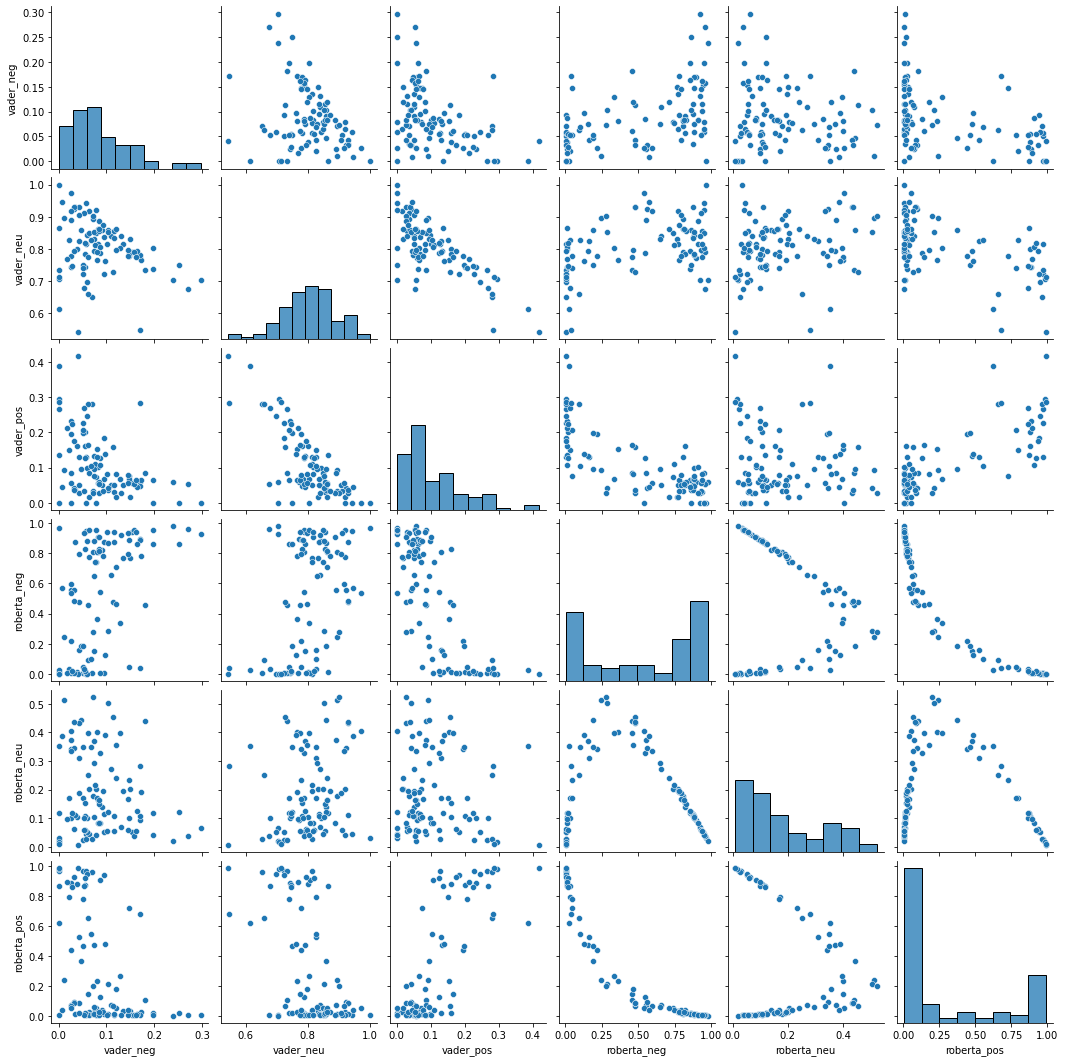

In [32]:
import seaborn as sns
sns.pairplot(data=results_df, 
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
             palette='tab10')
plt.show()

As we can see there are some sort of correlation between Vader and Roberta results

# Results & Conlusions
As we can see there are much more negative reviews than positive reviews

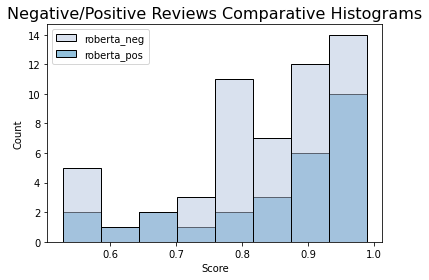

In [33]:
#fig, ax = plt.subplots(2, 1, figsize=(16, 5))
sns.histplot([results_df.query('roberta_neg >= 0.5')['roberta_neg'], 
              results_df.query('roberta_pos >= 0.5')['roberta_pos']],
              palette = 'PuBu')
plt.xlabel('Score')
plt.title('Negative/Positive Reviews Comparative Histograms', fontsize=16)
plt.show()

There are almost no neutral reviews. This means the majority of reviews were polarised as either positive or negative.

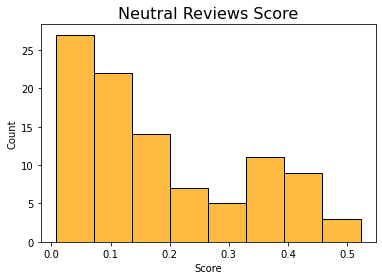

In [34]:
sns.histplot(results_df['roberta_neu'],  color = 'orange')
plt.title('Neutral Reviews Score', fontsize=16)
plt.xlabel('Score')
plt.show()

In [35]:
# ratings' median values (from 1 to 5)
avr

Seat Comfort              3
Cabin Staff Service       4
Food & Beverages          3
Inflight Entertainment    3
Ground Service            3
Value For Money           3
Wifi & Connectivity       1
Recommended               0
dtype: int32

In [37]:
df1.Recommended.value_counts()/df1.Recommended.value_counts().sum()

0    0.579651
1    0.420349
Name: Recommended, dtype: float64

So roughly 58 % of all customers do not recommend and 42 % recommend services of airline.